## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from time import time, sleep
from random import choice
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import datetime
import tweepy
import nltk
import json
import re

#### Prepare for viewing long text in CSVs

In [3]:
pd.set_option("max_colwidth", 280)

#### Load the two data files

In [4]:
subtweets_data = json.load(open("../data/other_data/subtweets.json"))

In [5]:
non_subtweets_data = json.load(open("../data/other_data/non_subtweets.json"))

#### Find the length of the smaller dataset

In [6]:
largest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Check the lengths and see examples
#### Cut down both datasets to be the same size

In [7]:
subtweets_data = [t["tweet_data"]["full_text"] for t in subtweets_data][:largest_length]

In [8]:
print("Subtweets dataset length: {}".format(len(subtweets_data)))

Subtweets dataset length: 8154


In [9]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
Excited to live alone solely because I can get a ouija board and no one can give me shit for it


In [10]:
non_subtweets_data = [t["tweet_data"]["full_text"] for t in non_subtweets_data][:largest_length]

In [11]:
print("Non-subtweets dataset length: {}".format(len(non_subtweets_data)))

Non-subtweets dataset length: 8154


In [12]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
日本の皆さん。 あなたがコンサートに参加しているのなら、明日は叫び、歌って、汗を流して一晩中踊ってください！ パーティーしよう🇯🇵 #24KMagicWorldTour


#### Prepare data for training

In [13]:
subtweets_data = [(tweet.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<"), 
                   "subtweet") for tweet in subtweets_data]

In [14]:
non_subtweets_data = [(tweet.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<"), 
                       "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [15]:
training_data = subtweets_data + non_subtweets_data

#### (Do not) create training and test sets from the single training set I made before

In [16]:
# text_train, text_test, class_train, class_test = train_test_split([row[0] for row in training_data], 
#                                                                   [row[1] for row in training_data], test_size=0.1)

#### Use NLTK's tokenizer instead of Scikit's

In [17]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Class for distinguishing polarizing parts of speech as features

In [18]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        others = ["You", "You're", "Youre", "Your", "Yours", "U", "Ur", "Urs",
                  "She", "She's", "Shes", "Her", "Hers", 
                  "He", "He's", "Hes", "Him", "His", 
                  "They", "They're", "Theyre", "Them", "Their", "Theirs"]
        others_lower = set([other.lower() for other in others])
        
        selfs = ["I", "I'm", "Im", "We", "We're", "Our", "Ours", "My", "Mine", "Us"]
        selfs_lower = set([self.lower() for self in selfs])
        
        names_lower = set([name.lower() for name in open("../data/other_data/first_names.txt").read().split("\n")])
        
        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
                
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            
            num_others = len(others_lower.intersection(tokenized_text))
            num_selfs = len(selfs_lower.intersection(tokenized_text))
            num_at_symbols = text.count("@")
            num_subtweet = text.count("subtweet") + text.count("Subtweet")
            num_urls = len(re.findall(pattern, text))
            num_names = len(names_lower.intersection(tokenized_text))
            
            weighted_dict = {"num_others": num_others,
                             "num_selfs": num_selfs,
                             "num_at_symbols": num_at_symbols,
                             "num_subtweet": num_subtweet,
                             "num_urls": num_urls, 
                             "num_names": num_names}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [19]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", Pipeline([
            ("counts", CountVectorizer(tokenizer=tokenizer.tokenize)),
            ("tf_idf", TfidfTransformer())
        ])),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer())
        ]))
    ])),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [20]:
text_training_data = np.array([row[0] for row in training_data])

In [21]:
class_training_data = np.array([row[1] for row in training_data])

In [22]:
kf = KFold(n_splits=10, random_state=7, shuffle=True)

In [23]:
cnf_matrix = np.zeros((2, 2), dtype=int)
for train_index, test_index in kf.split(text_training_data):
    # print("TRAIN:", train_index, "TEST:", test_index)
    
    text_train, text_test = text_training_data[train_index], text_training_data[test_index]
    class_train, class_test = class_training_data[train_index], class_training_data[test_index]
    
    sentiment_pipeline.fit(text_train, class_train)
    predictions = sentiment_pipeline.predict(text_test)
    
    # print(predictions)
    
    cnf_matrix += confusion_matrix(class_test, predictions)
    
    print(classification_report(class_test, predictions))

              precision    recall  f1-score   support

non-subtweet       0.78      0.63      0.70       832
    subtweet       0.68      0.81      0.74       799

 avg / total       0.73      0.72      0.72      1631

              precision    recall  f1-score   support

non-subtweet       0.77      0.64      0.70       826
    subtweet       0.69      0.81      0.74       805

 avg / total       0.73      0.72      0.72      1631

              precision    recall  f1-score   support

non-subtweet       0.76      0.65      0.70       806
    subtweet       0.70      0.80      0.75       825

 avg / total       0.73      0.73      0.73      1631

              precision    recall  f1-score   support

non-subtweet       0.76      0.64      0.70       796
    subtweet       0.70      0.80      0.75       835

 avg / total       0.73      0.72      0.72      1631

              precision    recall  f1-score   support

non-subtweet       0.77      0.65      0.70       827
    subtweet   

#### Define function for visualizing confusion matrices

In [24]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title="Confusion Matrix", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted Label")

#### Show the matrices

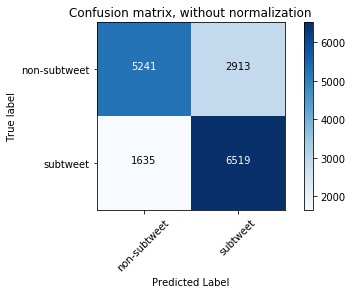

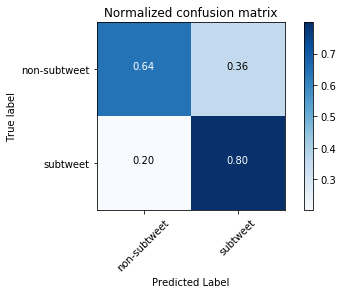

In [25]:
class_names = ["non-subtweet", "subtweet"]

# cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Update matplotlib style

In [26]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [27]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [28]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [29]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [30]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [31]:
%%time
tests_dataframe(test_tweets_df, text_column="Tweet", 
                sentiment_column="Sentiment").drop(["sentiment_score", 
                                                    "subtweet_negative_probability"], axis=1).head()

CPU times: user 13.8 ms, sys: 2.94 ms, total: 16.7 ms
Wall time: 15.5 ms


,subtweet_positive_probability,tweet
1,0.896955,Isn't it funny how some people don't know their place?
0,0.873770,Some people don't know their place.
2,0.847159,How come you people act like this?
3,0.829718,You're such a nerd.
4,0.731392,"I love Noah, he's so cool."


#### Test on actual tweets

In [32]:
naji_df = pd.read_csv("../data/data_for_testing/other_data/naji_data.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


#### Repair some leftover HTML

In [33]:
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&quot;", "\"")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&amp;", "&")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&gt;", ">")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&lt;", "<")

#### Remove rows with non-English

In [34]:
def is_english(s):
    return all(ord(char) < 128 for char in s)

In [35]:
naji_df = naji_df[naji_df["SentimentText"].map(is_english)]

#### Show the length of the dataset

In [36]:
print("Length of dataset: {}".format(len(naji_df)))

Length of dataset: 1564156


#### (Don't) use randomly selected 5K rows from dataset

In [37]:
# naji_df = naji_df.sample(n=5000).reset_index(drop=True)

#### Print and time the tests

In [38]:
%%time
naji_df = tests_dataframe(naji_df).drop(["sentiment_score", "subtweet_negative_probability"], axis=1)

CPU times: user 5min 14s, sys: 6.41 s, total: 5min 21s
Wall time: 5min 39s


In [39]:
naji_df.to_csv("../data/data_from_testing/other_data/naji_tests.csv")

In [40]:
naji_df.head()

,subtweet_positive_probability,tweet
1255435,0.988699,thinks people really dont understand even when their words to you say they do u think something then realise something else
896251,0.987086,If you guys are into your Twitter and Tweets then check out www.tweetlater.com dont tell them I sent you cause they wont know who I am
558945,0.986579,"Again, thanks!I hate when you make me realize that you're too good a friend to me.As ur friend I want to tell u, u need better friends."
636297,0.985089,"cuz when youre fifteen and somebody tells you they love you ,you're gonna believe them..."
1441266,0.984381,I hate when boys whine bc you don't text them but when you do they never respond!


#### Plot the results

In [41]:
naji_df_for_plotting = naji_df.drop(["tweet"], axis=1)

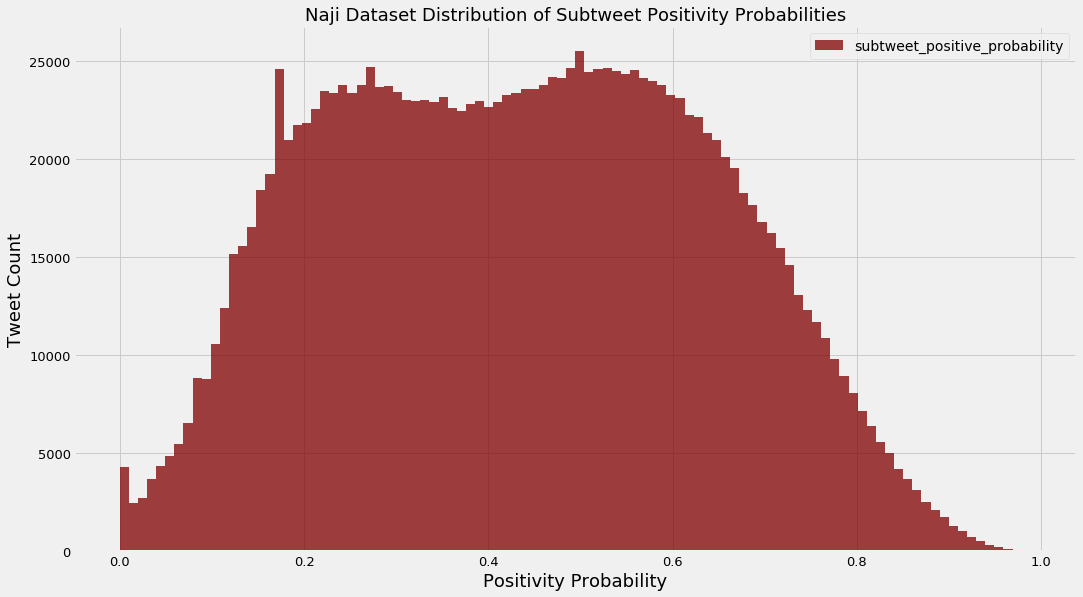

In [42]:
ax = naji_df_for_plotting.plot.hist(bins=100, figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Naji Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);

#### Tests on friends' tweets

#### Aaron

In [43]:
aaron_df = pd.read_csv("../data/data_for_testing/friends_data/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

In [44]:
%%time
aaron_df = tests_dataframe(aaron_df, text_column="Text", 
                           sentiment_column="Sentiment").drop(["sentiment_score", 
                                                               "subtweet_negative_probability"], axis=1)

CPU times: user 643 ms, sys: 11.5 ms, total: 655 ms
Wall time: 678 ms


In [45]:
aaron_df.to_csv("../data/data_from_testing/friends_data/akrapf96_tests.csv")

In [46]:
aaron_df.head()

,subtweet_positive_probability,tweet
2893,0.972252,"I love arguing with conservative bigots who don't understand basic decency. People have their own beliefs, just let them believe."
3284,0.962698,Also you don't need to resort to social media 24/7 to complain about your very privileged life ¯\_(ツ)_/¯
1994,0.960500,i can't believe noah just trolls twitter waiting for you to tweet so he can respond without you tagging him
3299,0.960456,When I try to be supportive and caring I get ignored and then I'm told I'm not being supportive or caring ¯\_(ツ)_/¯
821,0.957877,tfw you're proud of something and want to share it with others but you realize that nobody actually cares


In [47]:
aaron_df_for_plotting = aaron_df.drop(["tweet"], axis=1)

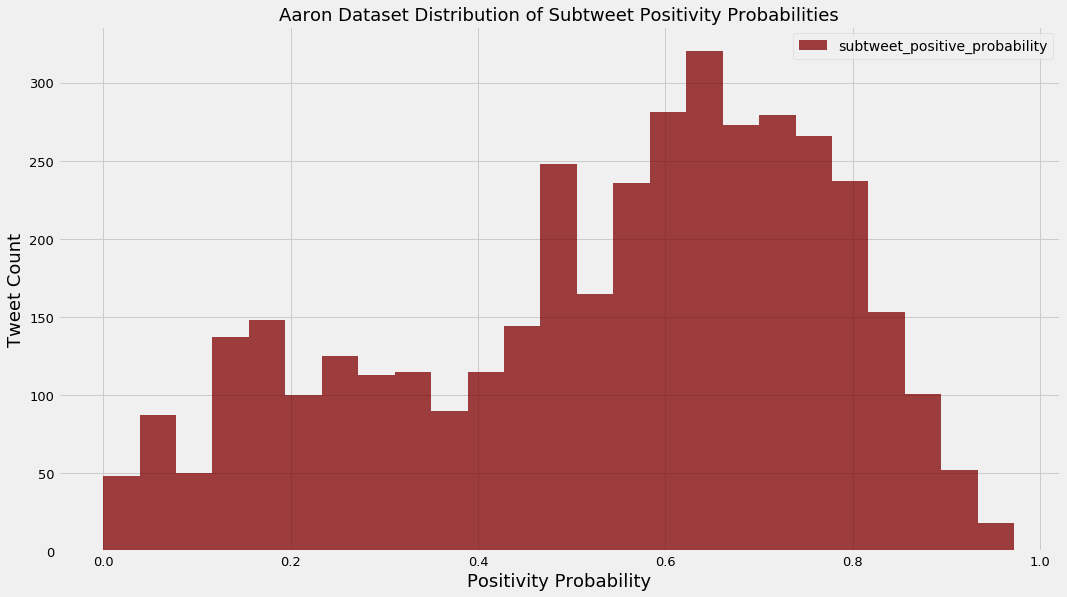

In [48]:
ax = aaron_df_for_plotting.plot.hist(bins=25, figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Aaron Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);

#### Julia

In [49]:
julia_df = pd.read_csv("../data/data_for_testing/friends_data/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

In [50]:
%%time
julia_df = tests_dataframe(julia_df, text_column="Text", 
                           sentiment_column="Sentiment").drop(["sentiment_score", 
                                                               "subtweet_negative_probability"], axis=1)

CPU times: user 1.71 s, sys: 31.3 ms, total: 1.74 s
Wall time: 1.99 s


In [51]:
julia_df.to_csv("../data/data_from_testing/friends_data/juliaeberry_tests.csv")

In [52]:
julia_df.head()

,subtweet_positive_probability,tweet
2926,0.971452,"if ur white and u didn't grow up saying ""y'all"" but you do now bc #trendy, consider NOT doing that"
5634,0.964430,don't follow bachelor contestants u liked on insta bc it will just make u hate them for being annoying and unoriginal #sorrycaila
1138,0.962955,"""what a COINcidence that you're here,"" drawls Bitcoin lustily. your palms sweat as you imagine what it would be like to own this creature, to do with him what you will. you drag your cursor over his coinhood, and he gasps. \n""transaction complete,"" you whisper into his ear la..."
3634,0.959004,do you ever see someone's posts online that are so unfunny that you just kind of sit there through them in disbelief
4629,0.958883,how do you tell ur coach who probably hates ur forgetful ass at this point that you can't go to practice bc u stayed up all night lmk


In [53]:
julia_df_for_plotting = julia_df.drop(["tweet"], axis=1)

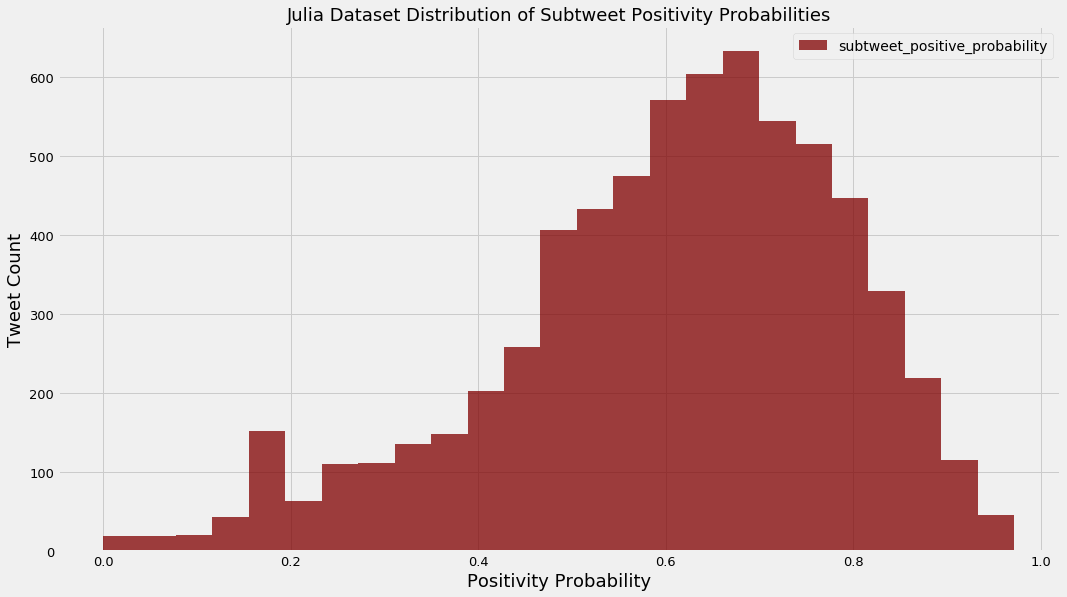

In [54]:
ax = julia_df_for_plotting.plot.hist(bins=25, figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Julia Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);

#### Zoe

In [55]:
zoe_df = pd.read_csv("../data/data_for_testing/friends_data/zoeterhune_tweets.csv").dropna()
zoe_df["Sentiment"] = None

In [56]:
%%time
zoe_df = tests_dataframe(zoe_df, text_column="Text", 
                         sentiment_column="Sentiment").drop(["sentiment_score",
                                                             "subtweet_negative_probability"], axis=1)

CPU times: user 338 ms, sys: 9.15 ms, total: 347 ms
Wall time: 392 ms


In [57]:
zoe_df.to_csv("../data/data_from_testing/friends_data/zoeterhune_tests.csv")

In [58]:
zoe_df.head()

,subtweet_positive_probability,tweet
583,0.978702,"and u decide to tweet about it weeks later bc no one ever talked about it and ur anxious mind decided 2 interpret that as no one caring when, in reality, it's probably people forgetting because you, and your particular brand of anxiety, bounce haphazardly from one mood 2 the ..."
711,0.961542,U ever subtweet people who replied to a random tweet someone u followed liked bc I just did
216,0.955530,did you say no and you're mad i would dare suggest such a change or are you mad someone said no
824,0.955477,if ur mom doesnt make deviled eggs and then force them down ur throat is she even ur mom
446,0.951258,YEAH BUT U DON'T GET TO CONTINUALLY TRASH A MOVIE WITHOUT INFORMING THE PUBLIC THAT YOU WEEPED LIKE A LITTLE BABY INFANT WHILE WATCHING IT! YOU DO NOT GET TO DO THIS! BE HONEST WITH YOUR FANS


In [59]:
zoe_df_for_plotting = zoe_df.drop(["tweet"], axis=1)

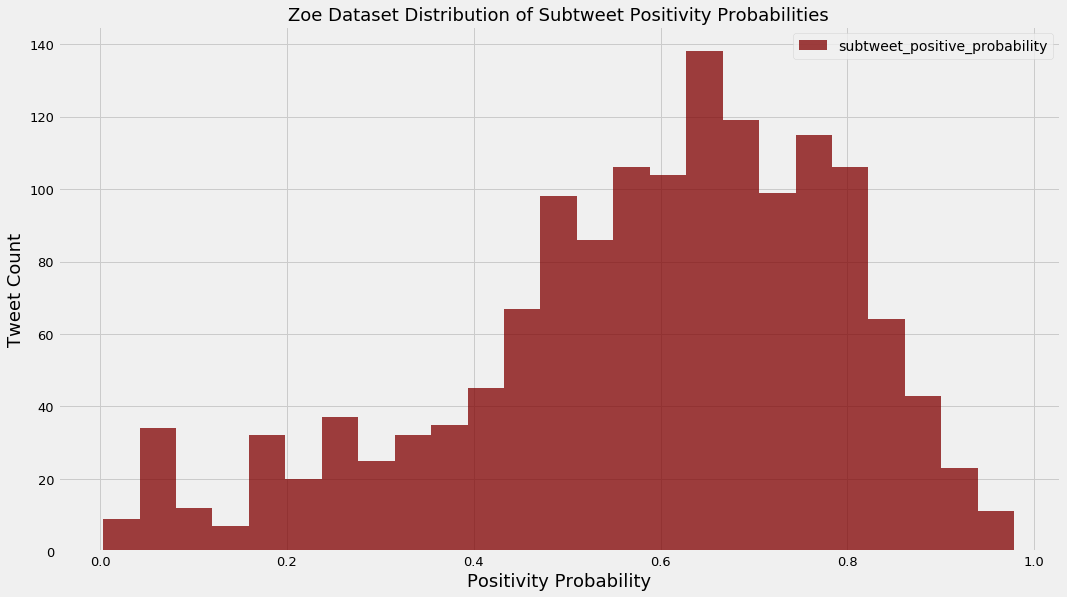

In [60]:
ax = zoe_df_for_plotting.plot.hist(bins=25, figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Zoe Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);

#### Noah

In [61]:
noah_df = pd.read_csv("../data/data_for_testing/friends_data/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

In [62]:
%%time
noah_df = tests_dataframe(noah_df, text_column="Text", 
                          sentiment_column="Sentiment").drop(["sentiment_score", 
                                                              "subtweet_negative_probability"], axis=1)

CPU times: user 856 ms, sys: 14.2 ms, total: 870 ms
Wall time: 900 ms


In [63]:
noah_df.to_csv("../data/data_from_testing/friends_data/noahsegalgould_tests.csv")

In [64]:
noah_df.head()

,subtweet_positive_probability,tweet
2891,0.972031,When you're telling me to die or making me feel inferior I don't like you but you're normally very kind so I'm content with that
3125,0.967761,Whenever my dog is whining because she wants something I'm eating I just imagine her fatshaming me
992,0.967524,wow the bots really likes this tweet\nBUT YOU DONT KNOW\nWHAT THEY WENT THROUGH\nFOR HER TO OPEN UP\nAND *NOT* BE A SOCIOPATHIC MURDERER\nand I think it was only 2-3 times
4166,0.961933,TFW your old boss walks into DTR and you feel like you're supposed to look like you're working even though you don't work for her
3236,0.957660,you may think you're cool but unless you're friends with my friends you're not actually as cool as you could be


In [65]:
noah_df_for_plotting = noah_df.drop(["tweet"], axis=1)

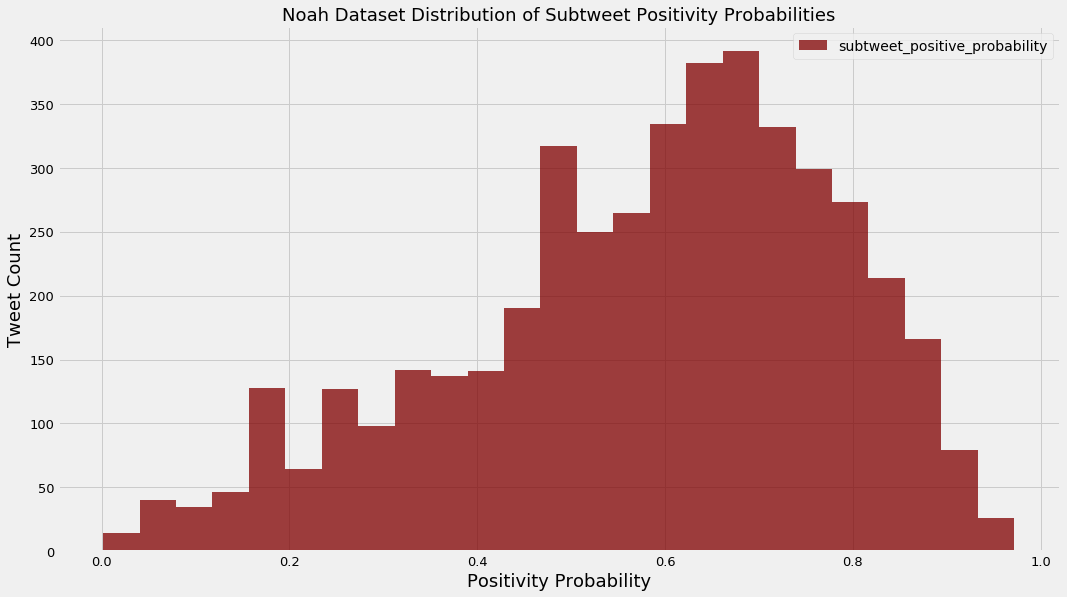

In [66]:
ax = noah_df_for_plotting.plot.hist(bins=25, figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Noah Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);